# Spam Classification

In this project I am going to build a spam-classifier by using the Naive Bayes algorithm on the SMS Spam Collection dataset.
I will use the bag-of-words (BOW) approach for the feature extraction process and evaluate the performance of our classifier with the confusion matrix.

### 1. Data Extraction

In [1]:
#Set working directory
import os
os.chdir("C:\\Users\\prii\\Dropbox\\Machine Learning Engineer\\Machine Learning\\Spam or Ham Classification Project")

In [2]:
import pandas as pd

#Load data
ham_spam_data = pd.read_csv('spam.csv', encoding='latin-1',usecols=["v1", "v2"])

#Print information about the dataset.
ham_spam_data.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   v1      5572 non-null   object
 1   v2      5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


This output shows us that our dataset contains 5572 entries and has two columns called "v1" and "v2". And the datatypes of the entries are objects. This means our text messages are stored as strings. How can we know what the colmn names "v1" and "v2" represents?
This can be answered with the pandas method "head":

### 2. Data Cleaning

In [3]:
#Disply the first 5 entries of the dataset
ham_spam_data.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


Now we can see that the column "v1" contains the labels and "v2" the actual text messages. I am going to rename the columns for simplicity.

In [4]:
#Relabel the columns
ham_spam_data.columns = ['label', 'text']


Now let us check if our dataset contains missing values (NAN-values)

In [5]:
#If value is zero, then the dataset (each column) does not have any missing values.
print(ham_spam_data.isnull().sum())


label    0
text     0
dtype: int64


Now let's generate descriptive statistics of the dataset. Note that our data contains only string values, that means we cannot display stats like mean or standarddeviation (std). 

In [6]:
#Display descriptive statistics
ham_spam_data.groupby('label').describe()


text                                                               
      count unique                                                top freq
label                                                                     
ham    4825   4516                             Sorry, I'll call later   30
spam    747    653  Please call our customer service representativ...    4

This table shows us, that we have 747 spam text messages and 4825 ham messages. Out of the 747 spam messages 653 messages are unique. For non-spam messages we have 4516 unique text messages. 
The most common non-spam message is "Sorry, I'll call later", which appeard 30 times. For spam messages the most common text message was "Please call our customer service representative...". Let's remove those duplicates.

In [7]:
#remove all duplicate values only in the column 'text'
ham_spam_data = ham_spam_data.drop_duplicates(subset = ['text'])


In [8]:
#Add another column called "label_bin". This will rename spam to 1 and ham to 0, it is needed for building the classifier. 
ham_spam_data['label_bin'] = ham_spam_data.label.map({'ham':0, 'spam':1})

### 3. Explanatory Data Analysis
Now let's do some explanatory data ananlysis
First,let's figure out how long the single text messages are

In [9]:
#We want to add a new feature text length, it will contain the length of each text message
ham_spam_data['text_len'] = ham_spam_data.text.apply(len)
ham_spam_data.head()

,label,text,label_bin,text_len
0,ham,"Go until jurong point, crazy.. Available only ...",0,111
1,ham,Ok lar... Joking wif u oni...,0,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1,155
3,ham,U dun say so early hor... U c already then say...,0,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",0,61


Now we will seperate the two categories ham and spam.

In [10]:
ham_text_len_stats = ham_spam_data[ham_spam_data.label == "ham"]["text_len"].describe()
spam_text_len_stats = ham_spam_data[ham_spam_data.label == "spam"]["text_len"].describe()

stats = pd.concat([ham_text_len_stats, spam_text_len_stats], axis = 1, keys = ['ham text length','spam text length'])
print(stats)

       ham text length  spam text length
count      4516.000000        653.000000
mean         70.459256        137.891271
std          56.358207         30.137753
min           2.000000         13.000000
25%          34.000000        132.000000
50%          52.000000        149.000000
75%          90.000000        157.000000
max         910.000000        224.000000


We can see that ham messages have on average 71 characters. The longest has 910 characters and the shortest 2 characters. Spam messages have on average 139 characters. The longest has 224 characters and the shortest has 13 characters. 
Now let us look at the boxplot of each category.

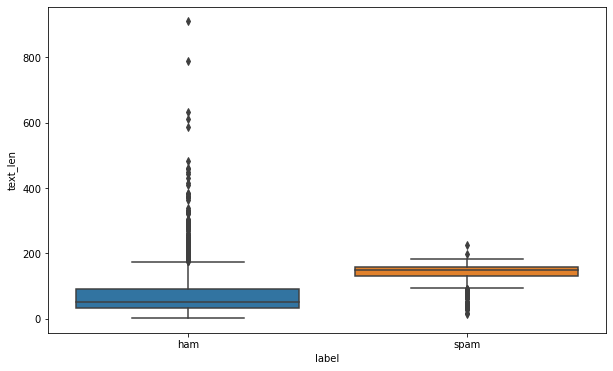

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,6))
sns.boxplot(x="label", y="text_len", data=ham_spam_data)

The first thing that pops up are the outliers in each group. It seem as though, ham messages have more outliers than spam messages. Secondly we can see that the text length of ham messages have a higher range, i.e. the text length of ham messages are more variable.
The boxplot shows that the distribution of ham messages text length and spam messages text length differs. Furthermore it seems that the distribution of the text length of ham messages are skewed right whereas the text length for spam messages it is skewed left.


No I want to create wordcloud, it is a way of displaying the most commonly appearing words in the dataset

(-0.5, 799.5, 799.5, -0.5)

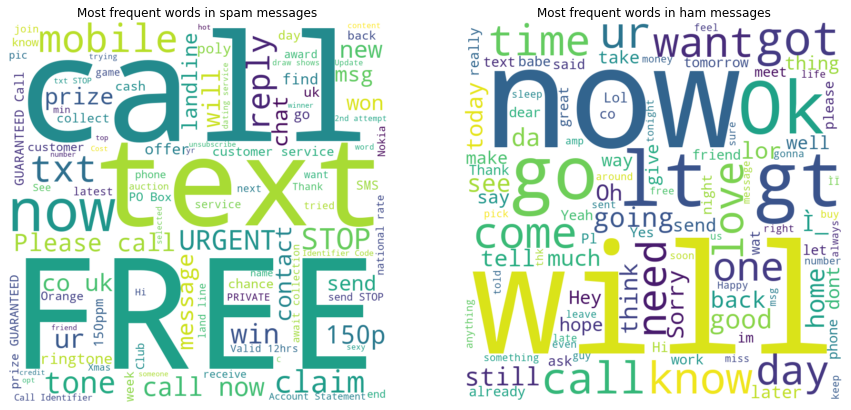

In [12]:
from wordcloud import WordCloud, STOPWORDS

#First we will remove all stopwords. Stop words are natural language words which have very little meaning, such as "and", 
#"the", "a", "an", and similar words.
stopwords = set(STOPWORDS)
spam_words =' '.join(list(ham_spam_data[ham_spam_data.label == "spam"]["text"]))
ham_words =' '.join(list(ham_spam_data[ham_spam_data.label == "ham"]["text"]))

fig, (ax1, ax2) = plt.subplots(1, 2,figsize = (15,15))
wc_spam = WordCloud(stopwords=stopwords, width = 800, height = 800, max_words=100,background_color="white").generate(spam_words)
wc_ham = WordCloud(stopwords=stopwords, width = 800, height = 800, max_words=100,background_color="white").generate(ham_words)
ax1.imshow(wc_spam, interpolation = "bilinear")
ax2.imshow(wc_ham, interpolation = "bilinear")
ax1.title.set_text('Most frequent words in spam messages')
ax2.title.set_text('Most frequent words in ham messages')
ax1.axis('off')
ax2.axis('off')
#plt.tight_layout(pad = 0)
#plt.show()

We can see on the image that the most frequent words in spam text messages are  "FREE", "call" and "text". For ham messages the most used words are "will", "now", "lt" and "gt". 


### 4. Build classification model

In order to build the classification model. I need to transform our text data into a matrix or vector so that it can be used for machine learning algorithms. The text processing step is known as feature extraction. There are two popular ways of representing text data in machine learning, Bag-of-Words (BoW) and TF-IDF. 

For this project we will use the BoW method. It is a very simple but effective. It takes the whole words that appear in the dataset, save it as a dictionary and mark how often each word appear in the dataset. Note that it is important to discard words, that are not significantly important e.g. "a", "I". Of course this depends on your dataset, for example if you want to build a classifier on a dataset which contain reviews of a movie it is crucial to keep words like "hate", "love","like", etc.

The following steps have to be taken to achieve the BoW representation:

Step 1: Tokenization/Text-preprocessing
Split the words of each text on whitespace or punctuation and save it as list.

Step 2: Vocabulary building
Create a dictionary that contains all the unique words that appear in the dataset and order them alphabetically.

Step 3: Encoding/Text vectorization
Create a feature matrix, the rows represent each pre-processed text (e.g. review, text message) in the dataset and the columns represent the words that appear in the pre-processed text. The entries of the matrix of features represent how often a word occurs in the text. For example, if the word appears once, we assign the value 1. If it does not appear we assign 0 and so on.

#### 4.1. Bag of words
##### Step 1:

In [13]:
import string
punc = string.punctuation #punc will contain all punctuations !"#$%&'()*+,-./:;<=>?@[\]^_`{|}~
def clean_messages(text):
    for i in punc:
        text = text.replace(i,'')
    return text

ham_spam_data['text'] = ham_spam_data['text'].apply(clean_messages)
print(ham_spam_data['text'])

0       Go until jurong point crazy Available only in ...
1                                 Ok lar Joking wif u oni
2       Free entry in 2 a wkly comp to win FA Cup fina...
3             U dun say so early hor U c already then say
4       Nah I dont think he goes to usf he lives aroun...
                              ...                        
5567    This is the 2nd time we have tried 2 contact u...
5568                  Will Ì b going to esplanade fr home
5569    Pity  was in mood for that Soany other suggest...
5570    The guy did some bitching but I acted like id ...
5571                            Rofl Its true to its name
Name: text, Length: 5169, dtype: object


In [14]:
import nltk
from nltk.corpus import stopwords
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [15]:
#split words

def split_text(text):
    text = text.split(' ')
    return text
#represent all words as lowercase characters
def lower_case(text):
    text = [word.lower() for word in text]
    return text
#We will remove all unnecessary words in the text messages
stop_words = stopwords.words('english') + [ 'ü', 'ur', 'im', 'dont', 'doin', 'ure','the','r','c','u','4','2']
def remove_stopwords(text):
    text = [word for word in text if not word in stop_words]
    return text

ham_spam_data['text'] = ham_spam_data['text'].apply(split_text)
ham_spam_data['text'] = ham_spam_data['text'].apply(lower_case)
ham_spam_data['text'] = ham_spam_data['text'].apply(remove_stopwords)



Before proceeding with step 2, we will split the data into training and test sets.

In [16]:
from sklearn.model_selection import train_test_split
X = ham_spam_data["text"]
y = ham_spam_data["label_bin"]
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.20, random_state = 42)
print("The training set contains",X_train.shape[0], "feature vectors and labels. \n")
print("The test set contains",X_test.shape[0], "feature vectors and labels")

The training set contains 4135 feature vectors and labels. 

The test set contains 1034 feature vectors and labels


##### Step 2
Use training data to create a dictionary

In [17]:
from sklearn.feature_extraction.text import CountVectorizer
#vect = CountVectorizer()
#vect.fit(X_train)
#First save all the words in one list
all_words = list()
for l in X_train:
    all_words.extend(l)

#create dictionary
bow_dict = {}
for word in all_words:
    if not word in bow_dict.keys():
        bow_dict[word] = 1
    else:
        bow_dict[word] += 1  
#delete the list all_words since it won't be needed again
del all_words


##### Step 3
Create the Bag-of-Words representation for the training and test set.

In [18]:
import numpy as np
from scipy import sparse

#create empty feature matrix. The rows will contain each pre-processed sentences and the columns the words that occur in that sentence.
feature_matrix = np.empty((X_train.shape[0],len(bow_dict)), dtype=int)

#create a function that will transform each pre-processed sentence into a dictionary where the keys are the words and the values
#how often the words appear in the sentence.
def freq_words(text):
    dict_text = {}
    for word in text:
        if not word in dict_text.keys():
            dict_text[word] = 1
        else:
            dict_text[word] += 1
    return dict_text

#create new variable 'word_freq' in column
ham_spam_data['word_freq'] = ham_spam_data['text'].apply(freq_words)  

#now fill feature matrix:

def fill_feature_matrix(text):
    feat_vect = []
    for word in bow_dict.keys():
        if not word in text.keys():
            feat_vect.append(0)
        else:
             feat_vect.append(text[word])  
    return np.array(feat_vect)

#create new variable 'word_freq' in column
ham_spam_data['feature_vector'] = ham_spam_data['word_freq'].apply(fill_feature_matrix)    



Now can split the column 'feature_vector' and 'label_bin' in to test and training set.
Recall that we split the the column "text" into training/test set in order to create our bag of words. With the attribute random_state we will always get the same test/train -split.

In [19]:
X = ham_spam_data["feature_vector"]
y = ham_spam_data["label_bin"]
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.20, random_state = 42)

#Convert X_train, X_text, y_train and y_test to numpy arrays
y_train, y_test = y_train.to_numpy(), y_test.to_numpy()
X_train = np.array(X_train.values.tolist())
X_test = np.array(X_test.values.tolist())
X_train.shape
#convert to sparse matrix. This datatype is more efficient than numpy array when it comes to matrix multiplication
X_train = sparse.csr_matrix(X_train)
X_test = sparse.csr_matrix(X_test)

#### 4.2. Build Naive Bayes Classifier
Now the Naive Bayes Classifier can be build. 
Remark: What happens if a word in the test set appears that doesn't occur in the training data? Recall, the multinomial Naive Bayes estimates frequency-based probabilities. If a word in a document (sentence) does not occur in the bag of words, this probability will be zero and hence the posterior probability that the document (in our case message) is in class $C = \lbrace spam,ham \rbrace$ will be zero. To avoid such thing a smoothing paramter $\alpha$ is added to the numerator to avoid , where $\alpha \in [0,1]$. This procedure is called Laplace smoothing. Conventionally alpha is set equal 1.

In [20]:
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

#Call the multinomial Naive Bayes classifier. The smoothing parameter alpha is set to 1 by default.
nb = MultinomialNB();

#Fit classifier
nb.fit(X_train, y_train);



#### 4.3. Evaluate Classifier

In [21]:
y_pred = nb.predict(X_test)
n = y_test.shape[0]
confusion_mat = metrics.confusion_matrix(y_test, y_pred)
# calculate accuracy of class predictions
print("The Naive Bayes classifier has an accuracy of",metrics.accuracy_score(y_test, y_pred),"\n")
print("Size of test set: ",n,"\n")
print("The confusion matrix:\n ",confusion_mat)

The Naive Bayes classifier has an accuracy of 0.9825918762088974 

Size of test set:  1034 

The confusion matrix:
  [[884   5]
 [ 13 132]]


Now let's visualize the confusion matrix.

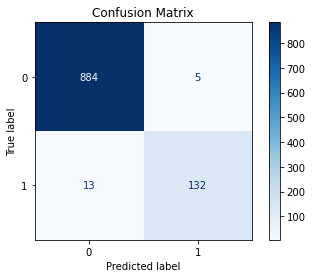

In [22]:

from sklearn.metrics import plot_confusion_matrix

fig1 = plot_confusion_matrix(nb, X_test, y_test,cmap=plt.cm.Blues)
fig1.ax_.set_title('Confusion Matrix')
plt.show()



The NB-Classifier classified 884 ham messages out of 889 correctly. Furthermore 132 out of 145 spam messages were classified
correctly. 5 ham messages were incorrectly classified as spam messages. On the other hand 13 spam messages were misclassified.
Now let's take a look at the normalized confusion matrix:

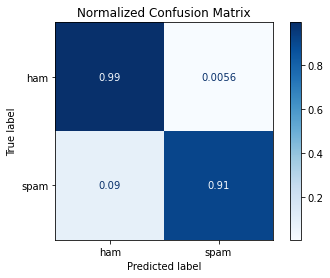

In [23]:
fig2 = plot_confusion_matrix(nb, X_test, y_test,cmap=plt.cm.Blues,normalize='true',display_labels = ["ham","spam"])
fig2.ax_.set_title('Normalized Confusion Matrix')
plt.show()

The normalized confusion matrix displays the different rates:
- Upper left: Defines the true negative rate (TNR). It measures the proportion of ham messages that are correctly classified.

$$TPR = \frac{\# \text{ correctly specified ham messages}}{\# \text{ ham messages in test set}} = 0.99$$

- Upper right: Defines the false positive rate (FPR). It tells us the poportion of ham messages that were misclassified by our model. Meaning, the model labeled the text message as spam even though it is not.

$$FPR = \frac{\# \text{ misspecified ham messages}}{\# \text{ ham messages in test set}} = 0.0056$$

- Lower left: Defines the false negative rate (FNR). It tells us the poportion of spam messages that were misclassified by our model. Meaning, the model labeled the text message as ham even though it is not.e.  

$$FNR = \frac{\# \text{ misspecified spam messages}}{\# \text{ spam messages in test set}} = 0.09$$

- Lower right: Defines the true positive rate (TNR). It measures the proportion of spam messages that are correctly classified.

$$TPR = \frac{\# \text{ correctly specified spam messages}}{\# \text{ spam messages in test set}} = 0.91$$

### 5. Outlook
There a different ways on how to improve the classifier. One of it is to collect more samples, especiall spam text messages.
An improvement can also be made in the tex processing part. For example we can use stemming and lemmatization, this method will transform related words to one. E.g., car, cars, car's, cars' -> car. Furthermore we can use bigrams instead of unigrams. In bigrams, we seperate a document in a sequence of two words.
